# Regression Coefficients Nullspace Perspective
This notebook contains contains examples and visualizations of the nullspace perspective for regression in high dimensions. 
Corresponding paper: 

Contact: Joachim Schaeffer, joachim.schaeffer@posteo.de

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_decomposition import PLSRegression

# IPython Libraries
import IPython

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)

# Custom functions
import src.basis as basis
from src.data_gen import generate_target_values

from src.helper import construct_data
from src.helper import optimise_pls_cv

In [2]:
# Varibles to set. 
# Paths are OS dependent.

# Shall plots be saved?
save_plots = True

# Path to save plots
save_plot_path = './../Nullspace/Figures/' 
# save_plot_path = './results/' 

plt.style.use('./styles/plots.mplstyle')

# Plot additional visualizations.
extra_plots = 0

# Load data that was used for the publication
# Is set to true, the data for the plots will be loaded from csv files. 
# If set to false the data will be generated and figures might differ slightly due to the random structure of the noise.
load_data = True

# If load data=False and save_data=True, the csv files will be replaced with the data genearated during this run.
save_data = False

In [3]:
# Create PLS Model objects. 
# You can also used RR or lasso or other models instead.

model_PLS1 = PLSRegression(n_components=1, tol=1e-7, scale=False)
model_PLS2 = PLSRegression(n_components=2, tol=1e-7, scale=False)
model_PLS3 = PLSRegression(n_components=3, tol=1e-7, scale=False)
model_PLS4 = PLSRegression(n_components=4, tol=1e-7, scale=False)

#### Generate Synthethic
Showcase of the Nullspace methodology on different examples.

Generate Synthethic dataset, using SynMLData class that inherits form the basis class. 

Example I: Parabolas

In [4]:
if not load_data:
    x_min = 1.0
    x_max = 3.0
    means = [0, 0, 0.3]
    stdv = [0, 0, 0.3]
    x = np.linspace(x_min, x_max, 200)[:, None]

    # Data without noise
    dml_parab = construct_data(
        x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0)

    # Data with noise
    dml_parab_n = construct_data(
        x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0)

    # True feature is the mean
    mean_function = lambda a : np.mean(a, axis=1)

    dml_parab = dml_parab.construct_y_data(mean_function)
    dml_parab_n = dml_parab_n.construct_y_data(mean_function)
    dml_parab_n = dml_parab_n.add_wgn(add_noise_X=True, snr_x=50, add_noise_y=True, snr_y=50)

    if save_data: 
        np.savetxt(
            "dml_parab.csv", np.hstack((dml_parab.X, np.expand_dims(dml_parab.y, axis=1))), delimiter=",", 
            header="Col. 0-49 X, poly. basis params.: means = [0, 0, 0.3], stdv = [0, 0, 0.3], y col. 50, sample mean, prior to noise")
        np.savetxt(
            "dml_parab_n.csv", np.hstack((dml_parab_n.X, np.expand_dims(dml_parab_n.y, axis=1))), delimiter=",", 
            header="Col. 0-49 X, poly. basis params.: means = [0, 0, 0.3], stdv = [0, 0, 0.3], y col. 50, sample mean, prior to noise")
else: 
    temp = np.loadtxt('dml_parab.csv', skiprows=1, delimiter=',') 
    temp_n = np.loadtxt('dml_parab_n.csv', skiprows=1, delimiter=',') 
    # Parameters from header ofcsv file
    x = np.linspace(1.0, 3.0, temp[:,:-1].shape[1])[:, None]

    dml_parab = basis.SynMLData(None, None).place_X_y(temp[:,:-1], x, temp[:,-1])
    dml_parab_n = basis.SynMLData(None, None).place_X_y(temp_n[:,:-1], x, temp_n[:,-1])

mean_reg_coef = (1/dml_parab.X.shape[1]) * np.ones(dml_parab.X.shape[1])

In [6]:
# Learn the weights (aka regression coefficients), using the models defined above.
dml_parab = dml_parab.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_parab_n = dml_parab_n.learn_weights(model_PLS1, 'PLS 1 Comp.')

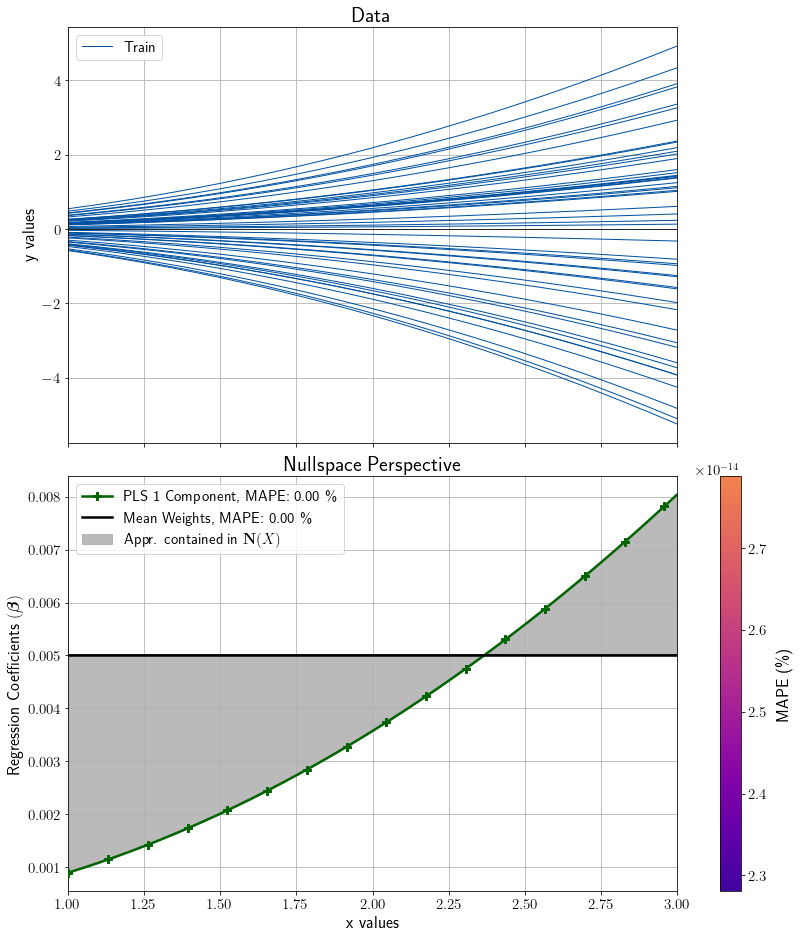

In [7]:
dml_parab, fig, ax = dml_parab.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='Polynomial_example.pdf')

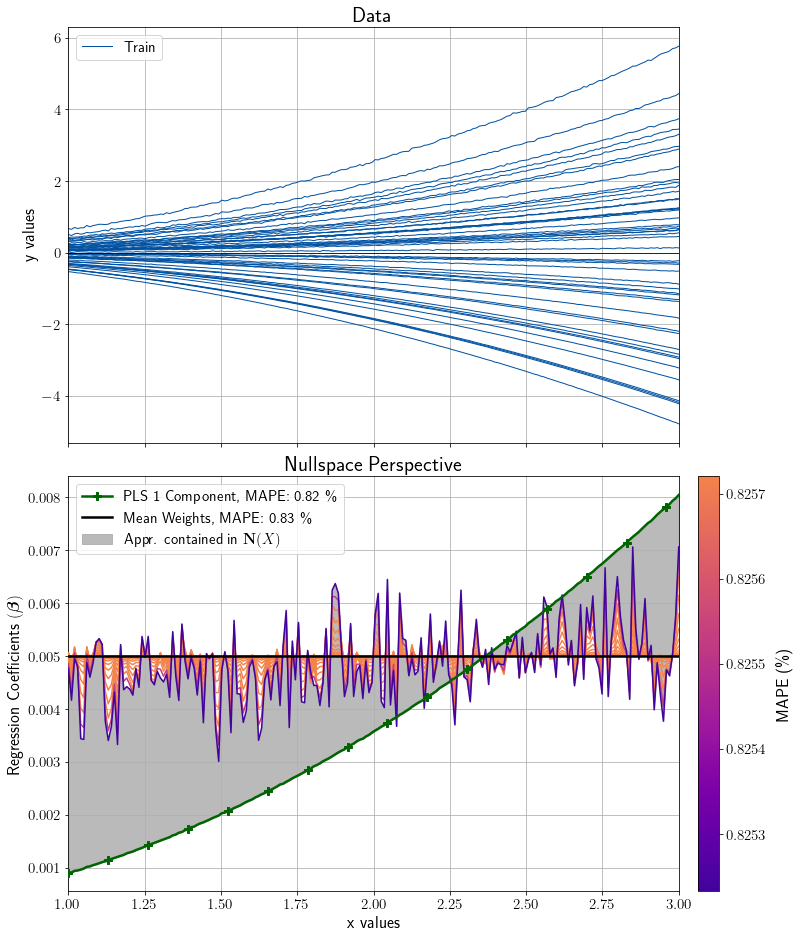

In [8]:
dml_parab_n, fig, ax = dml_parab_n.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='Polynomial_example_noise.pdf')

# ax[1].plot(dml_parab.x, dml_parab.weights_std['PLS 1 Comp. std'])
# ax[1].plot(dml_parab.x, dml_parab.weights_std_retrans['PLS 1 Comp. std retrans'])
# if save_plots:
#     fig.savefig(save_plot_path + 'Polynomial_example_noise.pdf')

# Example using LFP Data:

published with:
Data-driven prediction of battery cycle life before capacity degradation

https://www.nature.com/articles/s41560-019-0356-8

Source of data: 
https://data.matr.io/

License of LFP data: lfpdatalicense.txt

In [9]:
# Load the LFP Dataset
lfp_df = pd.read_csv('lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])    
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
# X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
# y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
# X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
# y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

y_lfp_train_syn = np.zeros(X_lfp_train.shape[0])
mean_function = lambda a: np.mean(a)
mean_reg_coef_lfp = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])

if not load_data: 
    y_lfp_train_syn = generate_target_values(X_lfp_train, mean_function, percentage_range_x_to_t=[0,1])
    # Contruct data object
    dml_lfp_syn = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfp_train_syn)
    # Add noise to target values
    dml_lfp_syn = dml_lfp_syn.add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)
    if save_data: 
        np.savetxt(
            "lfp_y_mean.csv", dml_lfp_syn.y, delimiter=",", 
            header="Sample Mean reposne for the LFP Data")
else:
    dml_lfp_syn = basis.SynMLData(None, None).place_X_y(
        X_lfp_train, x_lfp, np.loadtxt('lfp_y_mean.csv', skiprows=1, delimiter=','))

In [10]:
np.savetxt(
    "lfp_y_mean.csv", dml_lfp_syn.y, delimiter=",", 
    header="Sample Mean reposne for the LFP Data")

In [11]:
# LFP dataset synthethic y
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS2, 'PLS 2 Comp.')
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS3, 'PLS 3 Comp.')
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS4, 'PLS 4 Comp.')
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS4, 'PLS 5 Comp.')

(array([2.20219500e-07, 2.68426469e-08, 1.08407823e-08, 8.03511222e-09,
        7.93890872e-09, 1.08823227e-08, 1.62787852e-08, 1.65140416e-08,
        1.74363892e-08, 2.20624470e-08]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

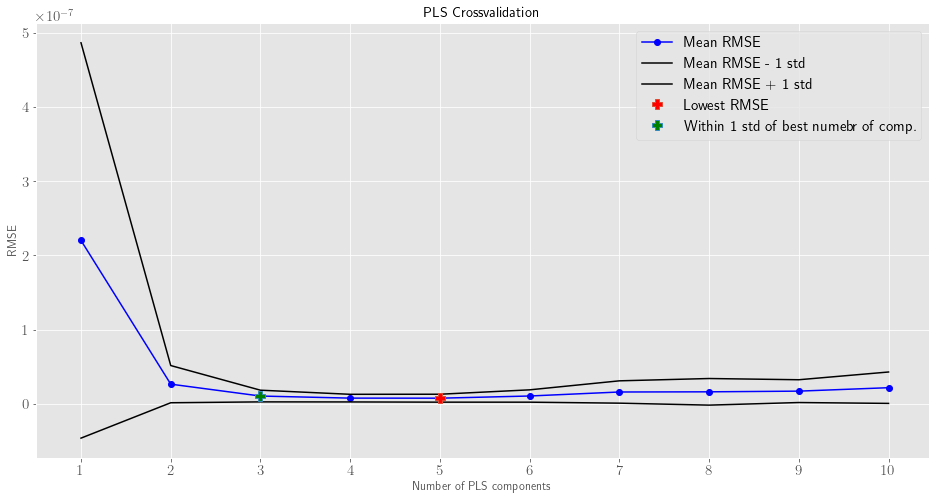

In [12]:
optimise_pls_cv(dml_lfp_syn.X_, dml_lfp_syn.y_, max_comps=10, plot_components=True, std=False)

(array([6.77048228e-07, 2.16754033e-07, 2.33415751e-08, 1.11521714e-08,
        6.88861331e-09, 9.69692807e-09, 1.36864727e-08, 1.96430159e-08,
        2.07993452e-08, 2.31247646e-08]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

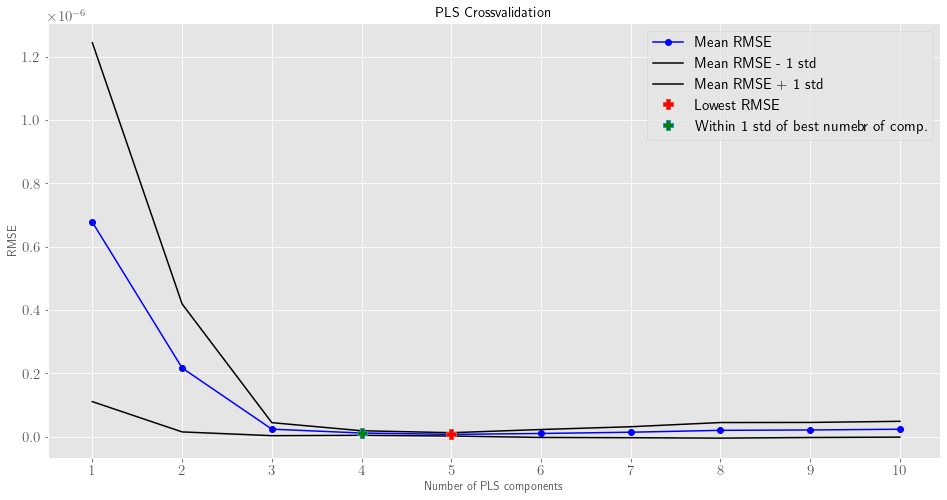

In [13]:
optimise_pls_cv(dml_lfp_syn.X_, dml_lfp_syn.y_, max_comps=10, plot_components=True, std=True)

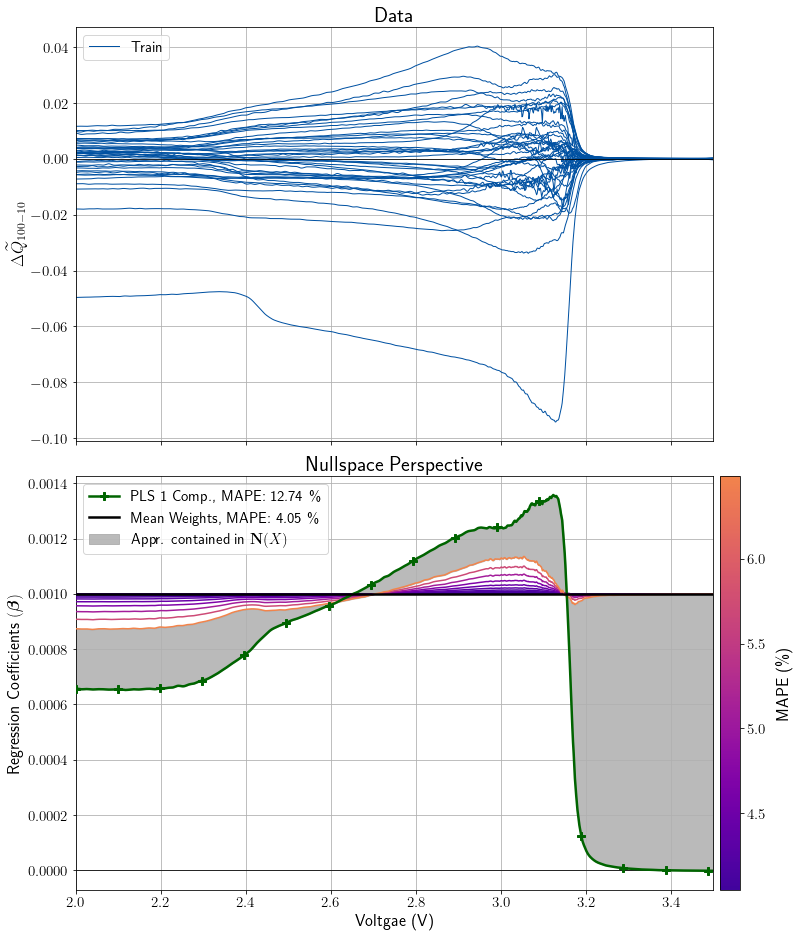

In [14]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 1 Comp.', w_alpha_name='PLS 1 Comp.', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=False, 
    plot_results=True, save_plot=0)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltgae (V)')    
plt.show()
fig.savefig(save_plot_path + 'LFP_example_PLS_mean.pdf') 

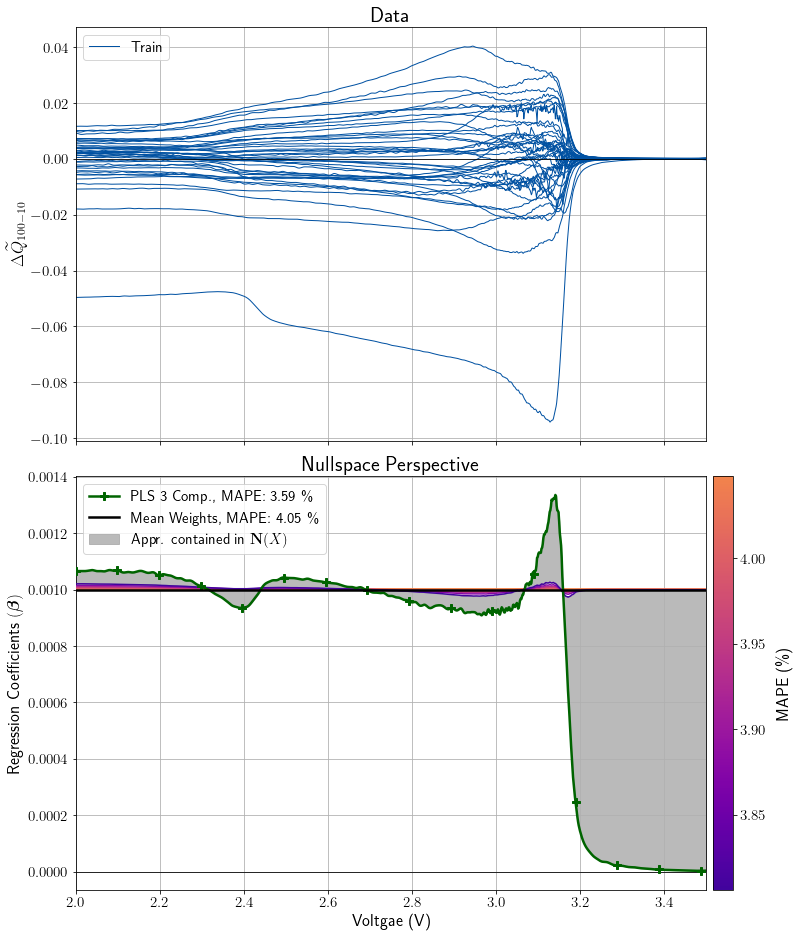

In [15]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 3 Comp.', w_alpha_name='PLS 3 Comp.', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=False, 
    plot_results=True, save_plot=0)


ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltgae (V)')    
plt.show()
fig.savefig(save_plot_path + 'LFP_example_3PLS_mean.pdf')

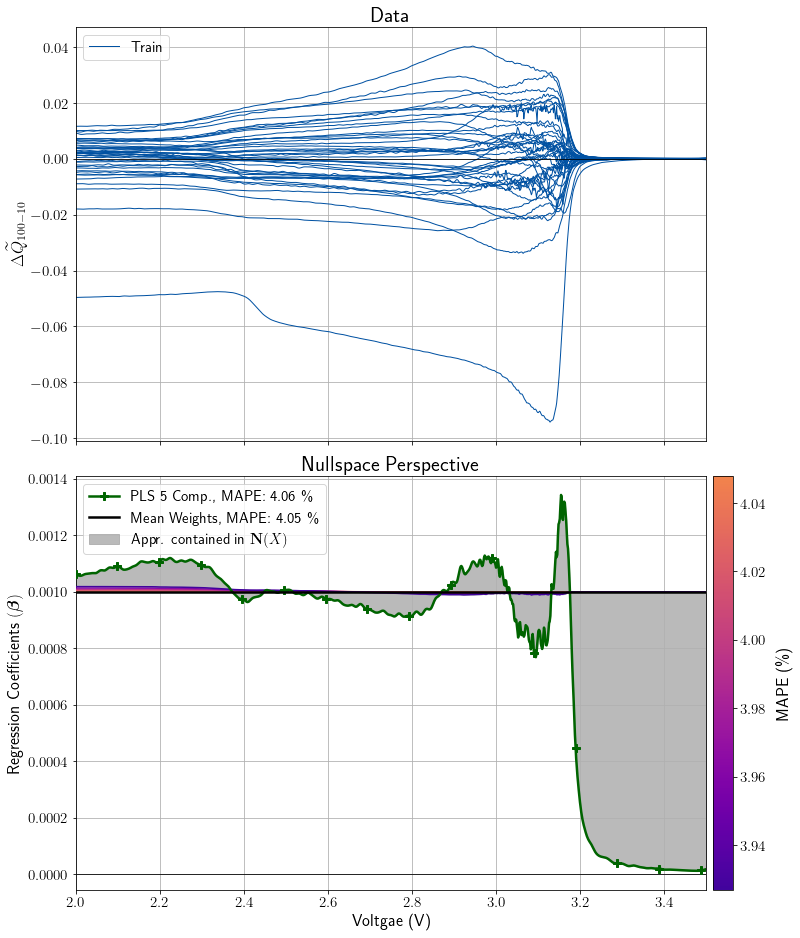

In [26]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 5 Comp.', w_alpha_name='PLS 5 Comp.', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=False, 
    plot_results=True, save_plot=0)


ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltgae (V)')    
plt.show()
fig.savefig(save_plot_path + 'LFP_example_4PLS_mean.pdf')

In [17]:
if extra_plots:
    plt.scatter(dml_lfp_syn.X@mean_reg_coef_lfp, dml_lfp_syn.X@dml_lfp_syn.weights['PLS 1 Comp.']+dml_lfp_syn.X@dml_lfp_syn.nullsp['v_'][-1, :])

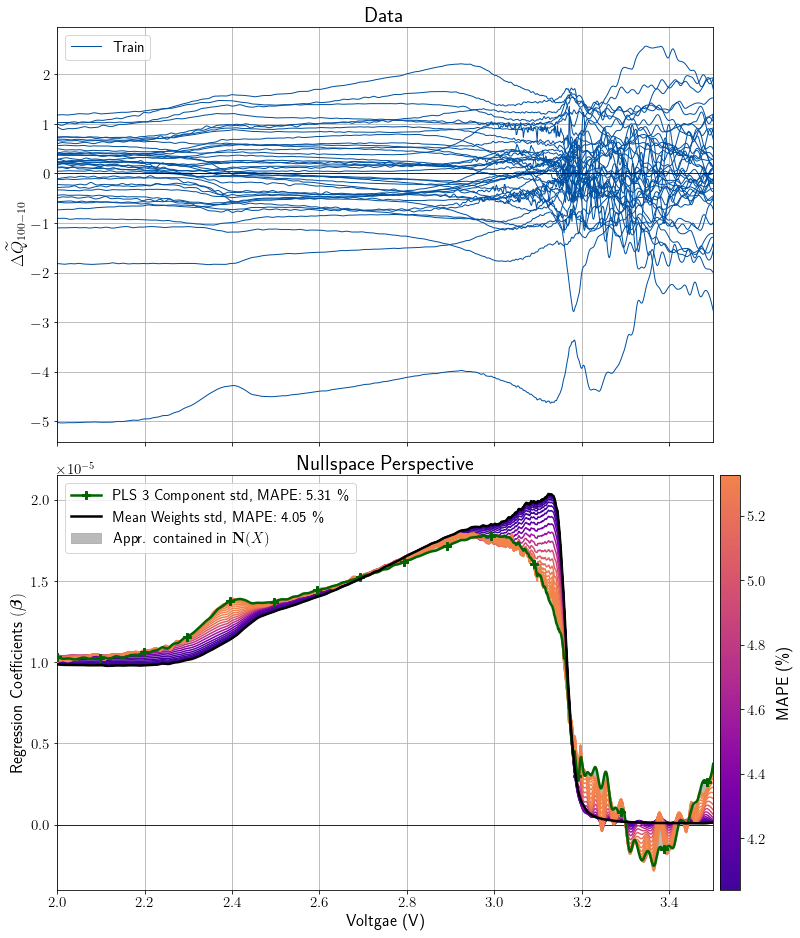

In [27]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha = 'PLS 3 Comp.', w_alpha_name='PLS 3 Component', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=True,
    plot_results=True, save_plot=0)

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltgae (V)')    
plt.show()
fig.savefig(save_plot_path + 'LFP_example_std_3PLS_mean.pdf')

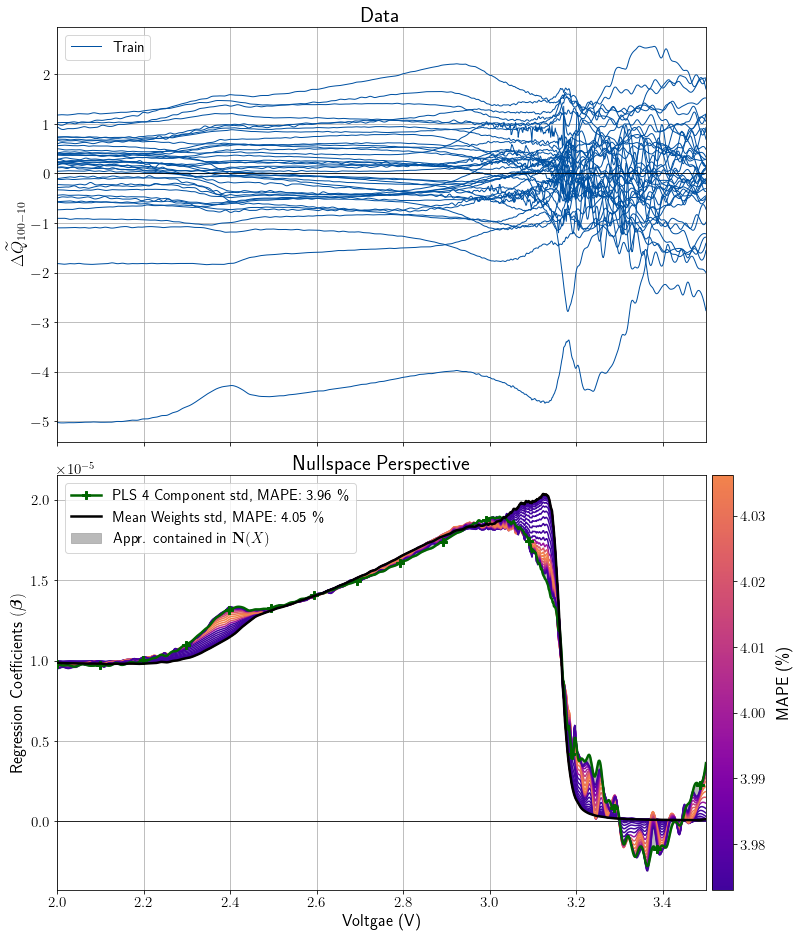

In [28]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha = 'PLS 4 Comp.', w_alpha_name='PLS 4 Component', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=True,
    plot_results=True, save_plot=0)

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltgae (V)')    
plt.show()
fig.savefig(save_plot_path + 'LFP_example_std_4PLS_mean.pdf')

In [20]:
if extra_plots:
    plt.plot(dml_lfp_syn.x, dml_lfp_syn.weights['PLS 1 Comp. std'], label='PLS1, X_std')
    plt.plot(dml_lfp_syn.x, mean_reg_coef_lfp*dml_lfp_syn.std, label='Mean weights*std')
    plt.ylabel('Voltage (V)')
    plt.xlabel('Regression Coefficients')
    plt.legend()
    plt.show()

### Colum mean weights

In [21]:
# Contruct data object
# data LFP Synthethic YTrue repsonse is X@column_mean 

rcoef_lfp_cm =  np.mean(X_lfp_train, axis=0)

if not load_data: 
    y_lfps_train_cm = np.dot(X_lfp_train, rcoef_lfp_cm)

    dml_lfps_cm = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfps_train_cm)
    # Add noise to target values
    dml_lfps_cm = dml_lfps_cm.add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)
    if save_data: 
        np.savetxt(
            "lfp_y_cm.csv", dml_lfps_cm.y, delimiter=",", 
            header="Column Mean response for the LFP Data")
else:
    dml_lfps_cm = basis.SynMLData(None, None).place_X_y(
        X_lfp_train, x_lfp, np.loadtxt('lfp_y_cm.csv', skiprows=1, delimiter=','))

dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS2, 'PLS 2 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS3, 'PLS 3 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS4, 'PLS 4 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS4, 'PLS 5 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS4, 'PLS 6 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS4, 'PLS 7 Comp.')

(array([6.88552151e-05, 1.84344246e-05, 1.16838999e-05, 9.72247408e-06,
        8.96153878e-06, 1.17978373e-05, 1.13559374e-05, 9.72941342e-06,
        9.92059159e-06, 9.86862565e-06]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

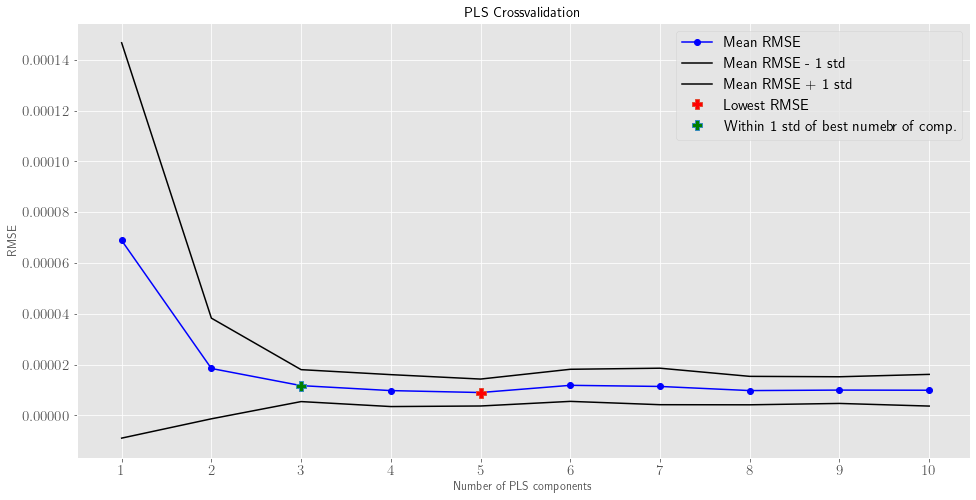

In [22]:
optimise_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=False)

(array([1.82973953e-03, 9.83120762e-04, 9.50104604e-05, 4.60664187e-05,
        1.89357005e-05, 1.25786015e-05, 1.20662301e-05, 1.63627021e-05,
        1.78372956e-05, 2.64740773e-05]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

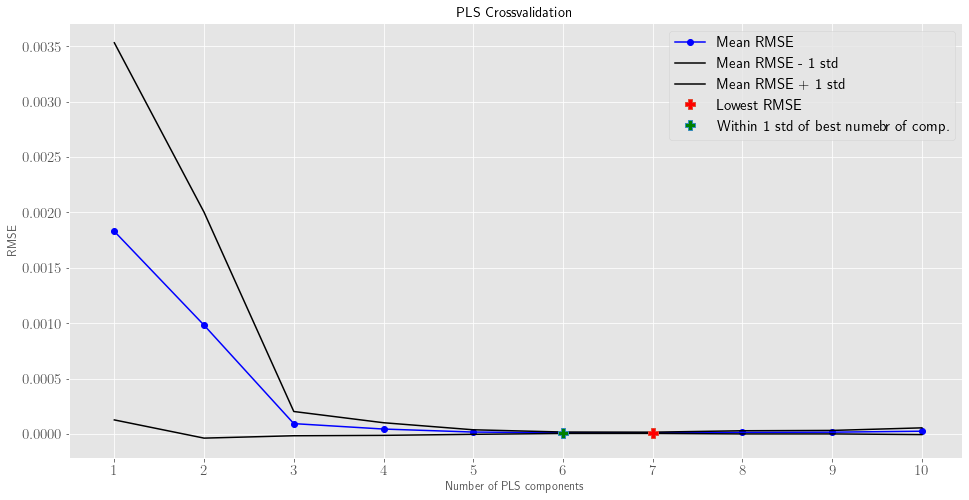

In [23]:
optimise_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=True)

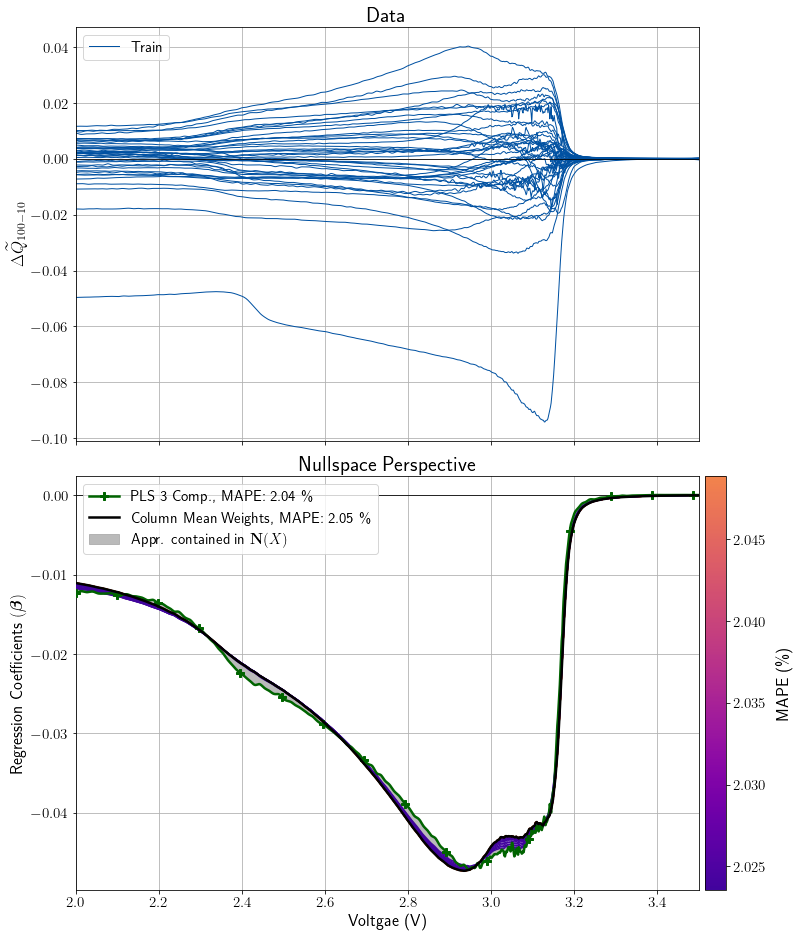

In [24]:
dml_lfps_cm, fig, ax = dml_lfps_cm.nullspace_correction(
    key_alpha ='PLS 3 Comp.', w_alpha_name='PLS 3 Comp.', 
    w_beta = rcoef_lfp_cm, w_beta_name='Column Mean Weights', std=False,
    plot_results=True, save_plot=0)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltgae (V)')    
plt.show()
fig.savefig(save_plot_path + 'LFP_3PLS_cm.pdf')

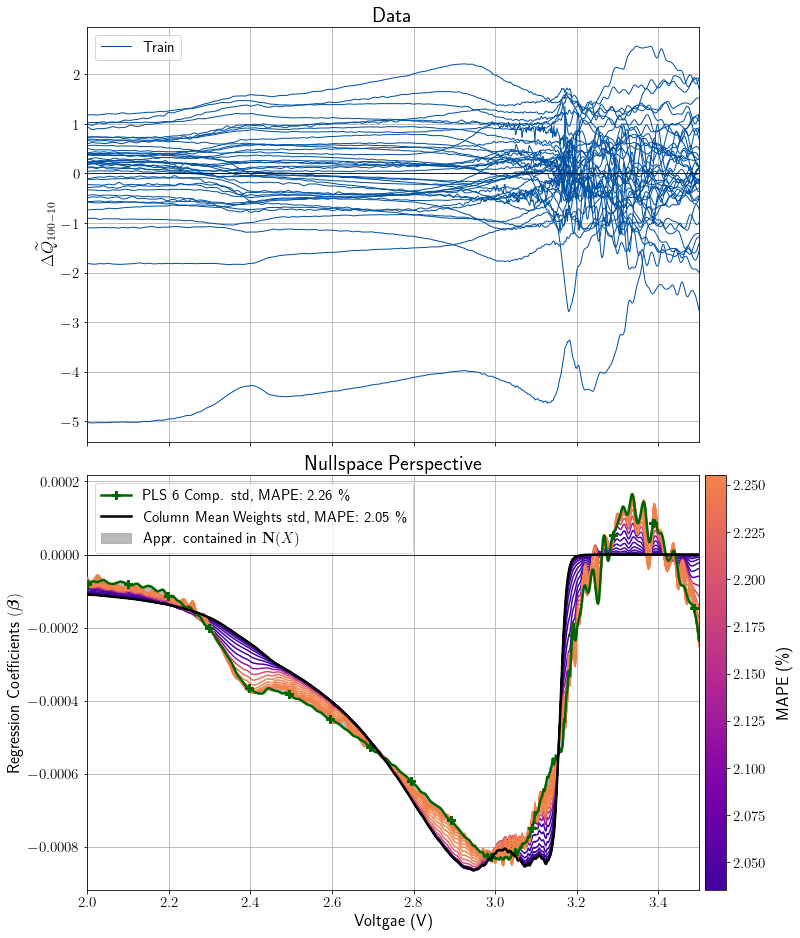

In [25]:
dml_lfps_cm, fig, ax = dml_lfps_cm.nullspace_correction(
    key_alpha ='PLS 6 Comp.', w_alpha_name='PLS 6 Comp.', 
    w_beta = rcoef_lfp_cm, w_beta_name='Column Mean Weights', std=True,
    plot_results=True, save_plot=save_plots)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltgae (V)')    
plt.show()
fig.savefig(save_plot_path + 'LFP_6PLS_cm_std.pdf')